In [7]:
import polars as pl
import numpy as np
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
commission = 0.25 / 10000.0

In [8]:
from datetime import timedelta

def aggregate_to_weekly(input_df, start_day_of_week):
    day_names = {1: "Monday", 2: "Tuesday", 3: "Wednesday", 4: "Thursday", 5: "Friday", 6: "Saturday", 7: "Sunday"}
    print(f"Aggregating daily bar to weekly, start from {day_names[start_day_of_week]}")

    def adjust_date(date):
        # Calculate the number of days to subtract to make 'start_day_of_week' the beginning of the week
        # We need to adjust the index by -1 since Python's weekday() returns Monday as 0, not 1
        weekday = date.dt.weekday()  # Monday is 0, Sunday is 6
        days_to_subtract = (weekday - (start_day_of_week - 1)) % 7
        return date - pl.duration(days=days_to_subtract)

    # Apply the adjustment to 'open_time'
    input_df = input_df.with_columns(
        adjust_date(pl.col("open_time")).alias("open_time")
    )

    # Group by 'symbol' and the adjusted week_start, then aggregate the columns
    weekly_df = input_df.groupby(["symbol", "open_time"]).agg([
        pl.col("open").first().alias("open"),     # Open of the first day in the week
        pl.col("high").max().alias("high"),       # Maximum high in the week
        pl.col("low").min().alias("low"),         # Minimum low in the week
        pl.col("close").last().alias("close"),   # Close of the last day in the week
        pl.col("close_time").last().alias("close_time"),
        pl.col("volume").sum().alias("volume"),  # Sum of volume in the week
        pl.col("quote_volume").sum().alias("quote_volume"), # Sum of quote_volume
        pl.col("count").sum().alias("count"),    # Sum of count
        pl.col("taker_buy_volume").sum().alias("taker_buy_volume"), # Sum of taker_buy_volume
        pl.col("taker_buy_quote_volume").sum().alias("taker_buy_quote_volume") # Sum of taker_buy_quote_volume
    ])

    return weekly_df

In [9]:
if 1:
    input_df = pl.read_parquet("data/agg_data_hour_to_day.parquet")
elif 1:
    input_df = pl.read_parquet("data/kline_1d_df.parquet")
    input_df = input_df.rename({"jj_code": "symbol"})
else:
    input_df = pl.read_parquet("data/daily_data.pa")

input_df = input_df.sort(['symbol', 'open_time'])


# # MA 10
# calc_factor = input_df.groupby('symbol').apply(
#     lambda df: df.with_columns(
#         (pl.col('close').rolling_mean(window_size=10)).alias('factor')
#         # (pl.col('close')).alias('factor')
#     )
# )

# # the return in the past 3 bar
# calc_factor = input_df.groupby('symbol').apply(
#     lambda df: df.with_columns(
#         # Calculate the return percentage compared to 10 time slices ago
#         ((pl.col('close') / pl.col('close').shift(3) - 1) * 100).alias('factor')
#     )
# )

# input_df = input_df.with_columns(
#     ((pl.col('close') / pl.col('close').shift(1) - 1) * 100).alias('return')
# )

input_df = input_df.sort(["symbol", "open_time"])
input_column_name = input_df.columns

print (input_df.columns)

AGG_TO_WEEK = 0

if AGG_TO_WEEK:
    input_df = aggregate_to_weekly(input_df, 1)
    assert sorted(input_df.columns) == sorted(input_column_name), f'before aggregate to week {sorted(input_column_name)}, but after is {sorted(input_df.columns)}' # the column should be the same
    input_df = input_df.sort(["symbol", "open_time"])

input_df


# 千万注意，这里是计算此时刻相对于前一时刻的return，不能使用未来信息 -> shift(1)是整体往下移动
input_df = input_df.with_columns(
    ((pl.col("close") / pl.col("close").shift(1) - 1) * 100)
    .over("symbol")  # Applying the function over each symbol group
    .alias("return")
).fill_null (0)


input_df = input_df.with_columns(
    pl.col("return").abs().rolling_sum(window_size=10).over("symbol").alias("rolling_abs_return_sum"),
    pl.col("quote_volume").rolling_sum(window_size=10).over("symbol").alias("rolling_quote_volume_sum")
)

input_df = input_df.with_columns(
    (pl.col("rolling_abs_return_sum") / pl.col("rolling_quote_volume_sum"))
    .over("symbol")  # Apply the final operation within each symbol group
    .alias("amihud")
).fill_null(0)

input_df = input_df.drop(["rolling_abs_return_sum", "rolling_volume_sum"])

input_df

['symbol', 'open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_volume', 'count', 'taker_buy_volume', 'taker_buy_quote_volume', 'ignore', 'open_time_ms', 'close_time_ms']


symbol,open_time,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,ignore,open_time_ms,close_time_ms,return,rolling_quote_volume_sum,amihud
str,datetime[ms],f64,f64,f64,f64,f64,datetime[ms],f64,i64,f64,f64,str,i64,i64,f64,f64,f64
"""1000BONKUSDT""",2023-11-22 14:00:00,0.00478,0.004858,0.004076,0.004389,2.3099e10,2023-11-23 13:59:59.999,1.0215e8,638151,1.1079e10,4.9046e7,"""0""",1700661600000,1700747999999,0.0,0.0,0.0
"""1000BONKUSDT""",2023-11-22 15:00:00,0.004282,0.004858,0.004076,0.004435,2.1790e10,2023-11-23 14:59:59.999,9.6347e7,617974,1.0431e10,4.6178e7,"""0""",1700665200000,1700751599999,1.048075,0.0,0.0
"""1000BONKUSDT""",2023-11-22 16:00:00,0.004254,0.004858,0.00415,0.004261,2.0189e10,2023-11-23 15:59:59.999,8.9573e7,600716,9.6039e9,4.2670e7,"""0""",1700668800000,1700755199999,-3.923337,0.0,0.0
"""1000BONKUSDT""",2023-11-22 17:00:00,0.004292,0.004858,0.00415,0.004286,1.9531e10,2023-11-23 16:59:59.999,8.6705e7,592413,9.2702e9,4.1214e7,"""0""",1700672400000,1700758799999,0.586717,0.0,0.0
"""1000BONKUSDT""",2023-11-22 18:00:00,0.004441,0.004858,0.004153,0.004244,1.8504e10,2023-11-23 17:59:59.999,8.2195e7,575711,8.7374e9,3.8874e7,"""0""",1700676000000,1700762399999,-0.979935,0.0,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""ZRXUSDT""",2024-09-21 04:00:00,0.3319,0.3451,0.3252,0.3306,3.7432e7,2024-09-22 03:59:59.999,1.2609e7,77171,1.7836e7,6.0077e6,"""0""",1726891200000,1726977599999,0.792683,1.2839e8,6.6622e-8
"""ZRXUSDT""",2024-09-21 05:00:00,0.3258,0.3451,0.3253,0.3305,3.5752e7,2024-09-22 04:59:59.999,1.2060e7,73923,1.7017e7,5.7394e6,"""0""",1726894800000,1726981199999,-0.030248,1.2751e8,6.5690e-8
"""ZRXUSDT""",2024-09-21 06:00:00,0.3291,0.3451,0.3266,0.3285,3.4266e7,2024-09-22 05:59:59.999,1.1571e7,70837,1.6170e7,5.4610e6,"""0""",1726898400000,1726984799999,-0.605144,1.2618e8,7.0478e-8


In [10]:
input_df['symbol'].unique().to_list()

['CELOUSDT',
 'ENJUSDT',
 'HBARUSDT',
 'AVAXUSDT',
 'COCOSUSDT',
 'ARUSDT',
 'ENSUSDT',
 'SXPUSDT',
 'XRPUSDT',
 'ALPHAUSDT',
 'ZKUSDT',
 'BNXUSDT',
 'PEOPLEUSDT',
 'ROSEUSDT',
 'ARPAUSDT',
 'XLMUSDT',
 'ASTRUSDT',
 'IDUSDT',
 'LTCUSDT',
 'BEAMXUSDT',
 'THETAUSDT',
 'TOKENUSDT',
 'IOUSDT',
 'XAIUSDT',
 'ZETAUSDT',
 'FTTUSDT',
 'OMNIUSDT',
 'OXTUSDT',
 'COTIUSDT',
 'ALGOUSDT',
 'KAVAUSDT',
 'AIUSDT',
 'EOSUSDT',
 'ANKRUSDT',
 '1000RATSUSDT',
 'YFIIUSDT',
 'CAKEUSDT',
 'STRKUSDT',
 'XTZUSDT',
 'RVNUSDT',
 'STMXUSDT',
 'INJUSDT',
 'DYMUSDT',
 'PHBUSDT',
 'HOTUSDT',
 'BCHUSDT',
 'POWRUSDT',
 'ARKMUSDT',
 'SNXUSDT',
 'EGLDUSDT',
 'FXSUSDT',
 'FOOTBALLUSDT',
 'ZILUSDT',
 'JASMYUSDT',
 'ENAUSDT',
 'DODOUSDT',
 'OMGUSDT',
 'DOTECOUSDT',
 'NUUSDT',
 'GLMUSDT',
 '1000XECUSDT',
 'RADUSDT',
 'GALUSDT',
 'BADGERUSDT',
 'AGLDUSDT',
 'REEFUSDT',
 'IDEXUSDT',
 'CFXUSDT',
 'ONTUSDT',
 'WLDUSDT',
 'CELRUSDT',
 'DYDXUSDT',
 'IOTAUSDT',
 'BLZUSDT',
 'LINKUSDT',
 'BONDUSDT',
 'HFTUSDT',
 'LUNAUSDT',
 'RSRU

In [11]:
import polars as pl
import numpy as np
from scipy.stats import kendalltau, skew, kurtosis, spearmanr


def calc_auto_kendall_corr(df: pl.DataFrame, result_column_name = 'return_auto_corr', lag_list: list = [1]) -> pl.DataFrame:
    input_list = df['return'].to_list()
    n = len(input_list)
    auto_corr_pearson = [[] for _ in range(len(lag_list))]
    auto_corr_spearman = [[] for _ in range(len(lag_list))]
    auto_corr_kendall = [[] for _ in range(len(lag_list))]
    running_skewness = []
    running_kurtosis = []

    # print (lag_list, len (lag_list))
    # print ('before start: ', len (auto_corr_pearson), len (auto_corr_spearman), len (auto_corr_kendall))
    
    for i in range(0, n):
        for lag_index, lag in enumerate(lag_list):
            # print ('i: ', i, '  lag_index: ', lag_index, '  lag: ', lag)
            # calc kendall tau auto_corr
            if i < lag:
                # auto_corr.append(np.nan)
                auto_corr_pearson[lag_index].append(np.nan)
                auto_corr_spearman[lag_index].append(np.nan)
                auto_corr_kendall[lag_index].append(np.nan)
            else:
                # print ('==== not NaN')
                a = input_list[lag:i + 1]
                b = input_list[0 : i + 1 - lag]

                auto_corr_pearson[lag_index].append(np.corrcoef(a, b)[0, 1])
                auto_corr_spearman[lag_index].append(spearmanr(a, b)[0])
                auto_corr_kendall[lag_index].append(kendalltau(a, b)[0])


        # calc skew
        current_skewness = skew(input_list[:i], bias=False) if i > 2 else np.nan  # skew requires at least 3 values to compute
        running_skewness.append(current_skewness)

        # calc kurtosis
        current_kurtosis = kurtosis(input_list[:i], bias=False) if i > 2 else np.nan  # kurtosis also requires at least 3 values
        running_kurtosis.append(current_kurtosis)
    
    # print (f'input: {df.shape} ===  skew {len(running_skewness)} == kurtosis {len(running_kurtosis)}')
    # for i in range(len(lag_list)):
    #     print (f'lag {lag_list[i]} === pearson {len(auto_corr_pearson[i])} == spearman {len(auto_corr_spearman[i])} == kendall {len(auto_corr_kendall[i])}')

    assert len (lag_list) == len (auto_corr_pearson) == len (auto_corr_spearman) == len (auto_corr_kendall), f'lag_list: {len(lag_list)} == auto_corr_pearson: {len(auto_corr_pearson)} == auto_corr_spearman: {len(auto_corr_spearman)} == auto_corr_kendall: {len(auto_corr_kendall)}'

    # auto_corr_series = [
    #     pl.Series(name=f'{result_column_name}_pearson_lag{lag}', values = cur_auto_corr_pearson),
    #     pl.Series(name=f'{result_column_name}_sprearman_lag{lag}', values = cur_auto_corr_sprearman),
    #     pl.Series(name=f'{result_column_name}_kendall_lag{lag}', values = cur_auto_corr_kendall)
    #     for lag, cur_auto_corr_pearson, cur_auto_corr_sprearman, cur_auto_corr_kendall in zip(lag_list, auto_corr_pearson, auto_corr_spearman, auto_corr_kendall)
    # ]

    # auto_corr_series = [
    # pl.Series(name=f'{result_column_name}_pearson_lag{lag}', values = auto_corr_pearson[lag_index])
    # # pl.Series(name=f'{result_column_name}_spearman_lag{lag}', values = auto_corr_spearman[lag_index]),
    # # pl.Series(name=f'{result_column_name}_kendall_lag{lag}', values = auto_corr_kendall[lag_index])
    # for lag_index, lag in enumerate(lag_list)
    # ]

    auto_corr_series = [
    series
    for lag_index, lag in enumerate(lag_list)
        for series in [
            pl.Series(name=f'{result_column_name}_pearson_lag{lag}', values=auto_corr_pearson[lag_index]),
            pl.Series(name=f'{result_column_name}_spearman_lag{lag}', values=auto_corr_spearman[lag_index]),
            pl.Series(name=f'{result_column_name}_kendall_lag{lag}', values=auto_corr_kendall[lag_index])
        ]
    ]

    additional_series = [
        pl.Series(name='return_skew', values=running_skewness),
        pl.Series(name='return_kurtosis', values=running_kurtosis)
    ]

    return df.with_columns (auto_corr_series + additional_series)

## Calc auto_corr for 'return' column

In [33]:
import os
LOAD_FILE_NO_CALC = 1
result_hour_path = 'data/result_hour.parquet'
result_hour_path = 'data/result_hour_alpha101.parquet'
result_hour_path = 'data/selected_factors_0916_0913.parquet'
result_hour_path = 'data/rolling_factors.parquet'
result_hour_path = 'data/linear_compound_factor.parquet'
result_hour_path = 'data/hour_agg_data.parquet'

if LOAD_FILE_NO_CALC:
    if os.path.exists(result_hour_path):
        result_hour = pl.read_parquet(result_hour_path)
    else:
        assert 0, 'miss file'
else:
    result_hour = input_df.clone()
    # result_hour = result_hour.groupby("symbol").apply(lambda group: calc_auto_kendall_corr(group,  'return_auto_corr_1', lag_list=[1, 2, 5, 10]))
    result_hour.write_parquet(result_hour_path)

result_hour

symbol,open_time,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,ignore,open_time_ms,close_time_ms,return,rolling_quote_volume_sum,amihud
str,datetime[ms],f64,f64,f64,f64,f64,datetime[ms],f64,i64,f64,f64,str,i64,i64,f64,f64,f64
"""1000BONKUSDT""",2023-11-22 14:00:00,0.00478,0.004858,0.004076,0.004389,2.3099e10,2023-11-23 13:59:59.999,1.0215e8,638151,1.1079e10,4.9046e7,"""0""",1700661600000,1700747999999,0.0,0.0,0.0
"""1000BONKUSDT""",2023-11-22 15:00:00,0.004282,0.004858,0.004076,0.004435,2.1790e10,2023-11-23 14:59:59.999,9.6347e7,617974,1.0431e10,4.6178e7,"""0""",1700665200000,1700751599999,1.048075,0.0,0.0
"""1000BONKUSDT""",2023-11-22 16:00:00,0.004254,0.004858,0.00415,0.004261,2.0189e10,2023-11-23 15:59:59.999,8.9573e7,600716,9.6039e9,4.2670e7,"""0""",1700668800000,1700755199999,-3.923337,0.0,0.0
"""1000BONKUSDT""",2023-11-22 17:00:00,0.004292,0.004858,0.00415,0.004286,1.9531e10,2023-11-23 16:59:59.999,8.6705e7,592413,9.2702e9,4.1214e7,"""0""",1700672400000,1700758799999,0.586717,0.0,0.0
"""1000BONKUSDT""",2023-11-22 18:00:00,0.004441,0.004858,0.004153,0.004244,1.8504e10,2023-11-23 17:59:59.999,8.2195e7,575711,8.7374e9,3.8874e7,"""0""",1700676000000,1700762399999,-0.979935,0.0,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""ZRXUSDT""",2024-09-21 04:00:00,0.3319,0.3451,0.3252,0.3306,3.7432e7,2024-09-22 03:59:59.999,1.2609e7,77171,1.7836e7,6.0077e6,"""0""",1726891200000,1726977599999,0.792683,1.2839e8,6.6622e-8
"""ZRXUSDT""",2024-09-21 05:00:00,0.3258,0.3451,0.3253,0.3305,3.5752e7,2024-09-22 04:59:59.999,1.2060e7,73923,1.7017e7,5.7394e6,"""0""",1726894800000,1726981199999,-0.030248,1.2751e8,6.5690e-8
"""ZRXUSDT""",2024-09-21 06:00:00,0.3291,0.3451,0.3266,0.3285,3.4266e7,2024-09-22 05:59:59.999,1.1571e7,70837,1.6170e7,5.4610e6,"""0""",1726898400000,1726984799999,-0.605144,1.2618e8,7.0478e-8


### Choose one factor to test (called FACTOR_NAME)

In [13]:
IF_NORM_FACTOR = 0
# FACTOR_NAME = 'return_auto_corr_2'
FACTOR_NAME = 'return_skew'
# FACTOR_NAME = 'return_kurtosis'
FACTOR_NAME = 'return_auto_corr_1_pearson_lag1'
# FACTOR_NAME = 'return_auto_corr_1_spearman_lag1'
# FACTOR_NAME = 'return_auto_corr_1_kendall_lag1'
# FACTOR_NAME = 'return_auto_corr_1_spearman_lag2'
# FACTOR_NAME = 'return_auto_corr_1_kendall_lag10'
# FACTOR_NAME = 'return_auto_corr_1_pearson_lag2'
# FACTOR_NAME = 'return_auto_corr_1_spearman_lag5'
# FACTOR_NAME = 'return_auto_corr_1_spearman_lag10'
# FACTOR_NAME = 'predict_factor'
FACTOR_NAME = 'alpha32'
FACTOR_NAME = 'amihud'
# FACTOR_NAME = 'alpha62'
FACTOR_NAME = result_hour.columns[17]
FACTOR_NAME = 'rolling_open_skew_40'    
FACTOR_NAME = 'linear_compound_factor_1day'

print ('FACTOR_NAME:', FACTOR_NAME)

close = result_hour[["open_time", "symbol", "close"]].pivot(index="open_time", columns="symbol", values="close").sort("open_time")
factors = result_hour[["open_time", "symbol", FACTOR_NAME]].pivot(index="open_time", columns="symbol", values = FACTOR_NAME).sort("open_time")

columns = close.columns[1:]
print (f'columns: {columns}')
print ('factors shape:', factors.shape)
# factors.fill_nan(0).describe()
factors.describe()

FACTOR_NAME: linear_compound_factor_1day
columns: ['WAVESUSDT', '1000FLOKIUSDT', 'YFIUSDT', 'CKBUSDT', 'ACHUSDT', 'ARKUSDT', 'SXPUSDT', '1000RATSUSDT', 'CTKUSDT', 'COMPUSDT', 'GLMRUSDT', 'HOOKUSDT', 'CRVUSDT', 'INJUSDT', 'CHRUSDT', 'STEEMUSDT', 'STPTUSDT', 'MANAUSDT', 'ZROUSDT', 'OGNUSDT', 'NEOUSDT', 'KNCUSDT', 'TLMUSDT', 'ETHFIUSDT', 'TAOUSDT', 'GASUSDT', 'XLMUSDT', 'THETAUSDT', 'JTOUSDT', 'LQTYUSDT', 'FILUSDT', 'PERPUSDT', 'UMAUSDT', 'HIGHUSDT', 'RVNUSDT', 'RADUSDT', 'GALUSDT', 'STRAXUSDT', 'FXSUSDT', 'BONDUSDT', 'MTLUSDT', 'FOOTBALLUSDT', 'RENUSDT', 'SNTUSDT', 'VETUSDT', 'ARKMUSDT', 'AVAXUSDT', 'MEMEUSDT', 'JOEUSDT', 'IOSTUSDT', 'RLCUSDT', 'AMBUSDT', 'BAKEUSDT', 'MEWUSDT', 'BLUEBIRDUSDT', '1000BONKUSDT', 'ONTUSDT', 'STORJUSDT', 'SUPERUSDT', 'AUDIOUSDT', 'BEAMXUSDT', 'FRONTUSDT', 'TNSRUSDT', 'USTCUSDT', 'STMXUSDT', 'DUSKUSDT', 'BICOUSDT', 'DASHUSDT', 'COMBOUSDT', 'LPTUSDT', 'APEUSDT', 'RNDRUSDT', 'DEFIUSDT', 'SUIUSDT', 'ICPUSDT', 'ONGUSDT', 'MASKUSDT', 'ENJUSDT', 'LSKUSDT', 'NEARUSDT

statistic,open_time,WAVESUSDT,1000FLOKIUSDT,YFIUSDT,CKBUSDT,ACHUSDT,ARKUSDT,SXPUSDT,1000RATSUSDT,CTKUSDT,COMPUSDT,GLMRUSDT,HOOKUSDT,CRVUSDT,INJUSDT,CHRUSDT,STEEMUSDT,STPTUSDT,MANAUSDT,ZROUSDT,OGNUSDT,NEOUSDT,KNCUSDT,TLMUSDT,ETHFIUSDT,TAOUSDT,GASUSDT,XLMUSDT,THETAUSDT,JTOUSDT,LQTYUSDT,FILUSDT,PERPUSDT,UMAUSDT,HIGHUSDT,RVNUSDT,…,1000PEPEUSDT,TONUSDT,BOMEUSDT,JASMYUSDT,C98USDT,LINAUSDT,DARUSDT,LTCUSDT,DODOXUSDT,XAIUSDT,MAVUSDT,XMRUSDT,BNXUSDT,SPELLUSDT,ETHUSDT,MDTUSDT,GTCUSDT,CTSIUSDT,MATICUSDT,HBARUSDT,BALUSDT,ARPAUSDT,STXUSDT,BTCUSDT,ZILUSDT,REEFUSDT,MKRUSDT,ENSUSDT,ICXUSDT,NTRNUSDT,KSMUSDT,OPUSDT,PEOPLEUSDT,OXTUSDT,ADAUSDT,CYBERUSDT,ONEUSDT
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""579""",523.0,438.0,579.0,505.0,511.0,302.0,579.0,215.0,453.0,579.0,201.0,541.0,579.0,579.0,579.0,252.0,179.0,579.0,27.0,579.0,579.0,579.0,475.0,121.0,97.0,266.0,579.0,579.0,222.0,495.0,579.0,499.0,434.0,526.0,579.0,…,439.0,138.0,123.0,579.0,579.0,579.0,579.0,579.0,344.0,190.0,384.0,579.0,511.0,579.0,579.0,301.0,579.0,579.0,579.0,579.0,579.0,579.0,512.0,579.0,579.0,579.0,579.0,579.0,579.0,246.0,579.0,579.0,579.0,341.0,579.0,331.0,579.0
"""null_count""","""0""",56.0,141.0,0.0,74.0,68.0,277.0,0.0,364.0,126.0,0.0,378.0,38.0,0.0,0.0,0.0,327.0,400.0,0.0,552.0,0.0,0.0,0.0,104.0,458.0,482.0,313.0,0.0,0.0,357.0,84.0,0.0,80.0,145.0,53.0,0.0,…,140.0,441.0,456.0,0.0,0.0,0.0,0.0,0.0,235.0,389.0,195.0,0.0,68.0,0.0,0.0,278.0,0.0,0.0,0.0,0.0,0.0,0.0,67.0,0.0,0.0,0.0,0.0,0.0,0.0,333.0,0.0,0.0,0.0,238.0,0.0,248.0,0.0
"""mean""","""2023-10-20 00:…",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,…,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"""std""",null,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,…,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"""min""","""2023-01-04 00:…",-3.8840e9,-3.7209e8,NaN,-6.4936e8,-2.3983e7,-3.6336e8,-9.2452e8,-4.6662e8,-9.2807e6,-2.6349e8,-2.8072e6,-6.8589e7,-1.1724e8,-3.5155e8,-4.5046e7,-2.5764e7,-1.2676e7,-1.5612e8,-1.4373e8,-8.5454e8,-5.7470e8,-2.4704e8,-1.0800e7,-2.7561e8,-1.0133e7,-5.8937e9,-8.2373e8,-4.4073e8,-1.1589e9,-3.0393e8,-7.5886e8,-3.3512e9,-4.2407e9,-9.2661e8,-4.7377e8,…,-3.0499e9,-1.2004e8,-9.6292e7,-4.9163e8,-3.2863e8,-1.6223e9,-3.6721e7,-6.0174e8,-2.7782e7,-1.2043e8,-1.2296e8,-5.2380e8,-1.7475e8,NaN,-2.0531e9,-5.6487e8,-2.9153e8,-4.5140e8,-2.3645e8,-3.5279e9,-1.2379e7,-3.5885e9,-3.2933e8,-3.2013e9,-1.3610e7,-6.2188e8,-8.1459e7,-1.0283e9,-1.3479e8,-1.4806e8,-4.0423e8,-5.4271e8,-5.3521e9,-2.4335e8,-1.2076e8,-2.4780e8,-1.5091e7
"""25%""","""2023-05-29 00:…",-731907.134964,NaN,NaN,NaN,-200425.800348,-546877.64499,-169565.417872,-3.0743e6,-22346.382507,-1.0057e6,NaN,-390425.58378,-209716.610717,-9.1639e6,-59594.298889,-34673.254929,-75649.574924,-220202.259433,-8.0322e7,NaN,-2.4405e6,-298347.594208,NaN,-6.9609e6,-2.1726e6,-4.2671e6,-252898.276251,-701104.156692,-1.0987e7,-665869.218768,-3.8695e6,-196625.482865,-838545.613798,-453928.847084,NaN,…,NaN,-1.4419e7,NaN,NaN,-95566.454086,NaN,-19300.193681,-7.8213e6,-59133.764058,-2.1628e6,-249742.420586,-413486.946646,-280022.373856,NaN,-2.0853e8,-47108.823852,-127013.812225,NaN,-5.1658e6,NaN,-91452.133354,-320003.203133,-1.3497e6,-3.9180e8,NaN,NaN,NaN,-2.6211e6,-62124.400674,-362886.192166,-210524.885775,-1.4263e7,NaN,NaN,-509976.777482,-3.1687e6,-131675.355516
"""50%""","""2023-10-20 00:…",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-161

    statistic  linear_compound_factor_1day
0       count                 1.216110e+05
1  null_count                 2.670000e+03
2        mean                -1.181489e+07
3         std                 1.254478e+08
4         min                -1.209879e+10
5         25%                -3.198803e+05
6         50%                 0.000000e+00
7         75%                 0.000000e+00
8         max                 0.000000e+00
[[-1.18148910e+07  1.25447772e+08]]
Values beyond 3 standard deviations: 76459
Percentage of total: 61.52%


<Figure size 1000x600 with 0 Axes>

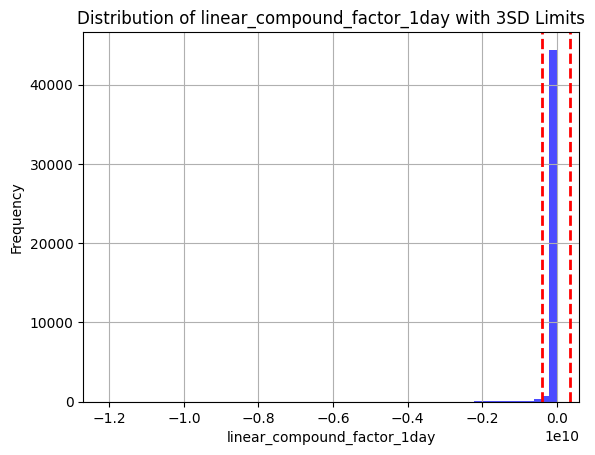

In [14]:
# 选择因子列
factor_data = result_hour.select(FACTOR_NAME).fill_nan(0)

# 计算描述性统计信息
descriptive_stats = factor_data.describe().to_pandas()  # 使用to_pandas()仅用于美观的输出
print(descriptive_stats)

# 计算均值和标准差
stats = result_hour.fill_nan(0).select([
    pl.col(FACTOR_NAME).mean().alias('mean'),
    pl.col(FACTOR_NAME).std().alias('std')
])

print (stats.to_numpy())

mean = stats.to_numpy()[0][0]
std = stats.to_numpy()[0][1]

# 计算3个标准差的范围
lower_bound = mean - 3 * std
upper_bound = mean + 3 * std

# 统计超出3个标准差的值的数量
outliers = result_hour.filter((pl.col(FACTOR_NAME) < lower_bound) | (pl.col(FACTOR_NAME) > upper_bound))
outlier_count = outliers.height

print(f'Values beyond 3 standard deviations: {outlier_count}')
print(f'Percentage of total: {(outlier_count / result_hour.height * 100):.2f}%')

# 可视化这些极端值
plt.figure(figsize=(10, 6))
result_hour.select(FACTOR_NAME).to_pandas().hist(bins=60, color='blue', alpha=0.7)
plt.axvline(lower_bound, color='red', linestyle='dashed', linewidth=2)
plt.axvline(upper_bound, color='red', linestyle='dashed', linewidth=2)
plt.title(f'Distribution of {FACTOR_NAME} with 3SD Limits')
plt.xlabel(FACTOR_NAME)
plt.ylabel('Frequency')
plt.show()

# # 使用when().then().otherwise()来替换值
# result_hour = result_hour.with_columns(
#     pl.when(pl.col(FACTOR_NAME) < lower_bound)
#     .then(lower_bound)
#     .when(pl.col(FACTOR_NAME) > upper_bound)
#     .then(upper_bound)
#     .otherwise(pl.col(FACTOR_NAME))
#     .alias(FACTOR_NAME)
# )

# # 验证结果
# print(result_hour.select(FACTOR_NAME).describe().to_pandas())
# plt.figure(figsize=(10, 6))
# # plt.title(f'Distribution of {FACTOR_NAME} after outlier removal')
# result_hour.select(FACTOR_NAME).to_pandas().hist(bins=160, color='blue', alpha=0.7)
# plt.show()

   lower_quantile  upper_quantile
0   -2.554744e+08             NaN
shape: (9, 2)
┌────────────┬─────────────────────────────┐
│ statistic  ┆ linear_compound_factor_1day │
│ ---        ┆ ---                         │
│ str        ┆ f64                         │
╞════════════╪═════════════════════════════╡
│ count      ┆ 121611.0                    │
│ null_count ┆ 2670.0                      │
│ mean       ┆ NaN                         │
│ std        ┆ NaN                         │
│ min        ┆ -2.5547e8                   │
│ 25%        ┆ -319880.347627              │
│ 50%        ┆ NaN                         │
│ 75%        ┆ NaN                         │
│ max        ┆ -310.939334                 │
└────────────┴─────────────────────────────┘


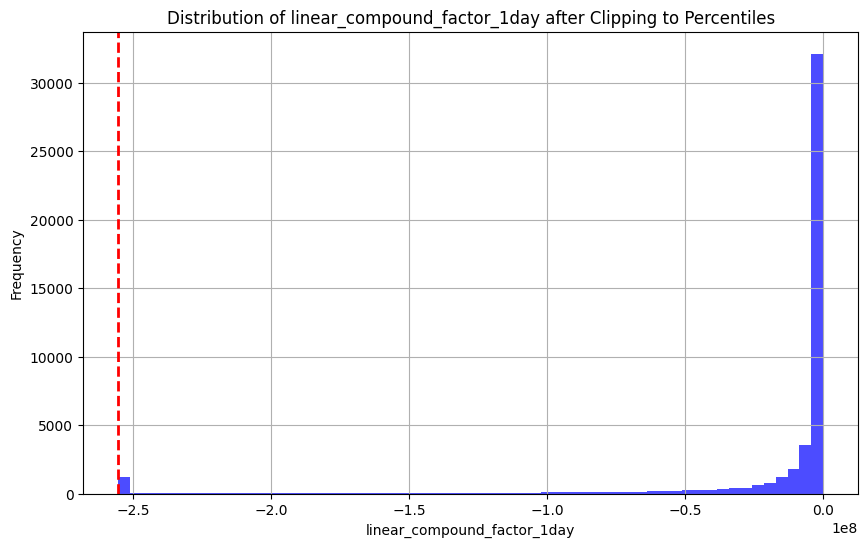

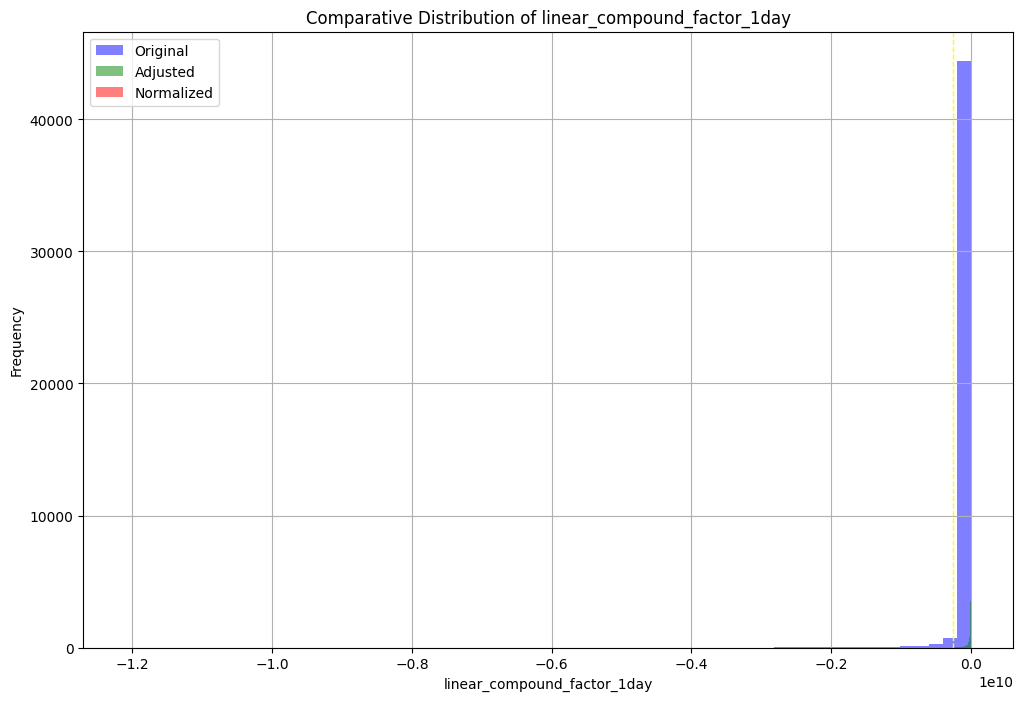

In [15]:
import polars as pl
import matplotlib.pyplot as plt

# Assuming FACTOR_NAME and result_hour are already defined

upper_pct = 0.99
lower_pct = 1 - upper_pct

# Calculate quantiles
quantiles_df = result_hour.select([
    pl.col(FACTOR_NAME).quantile(lower_pct).alias('lower_quantile'),
    pl.col(FACTOR_NAME).quantile(upper_pct).alias('upper_quantile')
]).to_pandas()

print (quantiles_df)

# Extract quantile values
lower_quantile = quantiles_df['lower_quantile'].iloc[0]
upper_quantile = quantiles_df['upper_quantile'].iloc[0]

# Replace values outside the quantile thresholds
result_hour_adjusted = result_hour.with_columns(
    pl.when(pl.col(FACTOR_NAME) < lower_quantile)
    .then(lower_quantile)
    .when(pl.col(FACTOR_NAME) > upper_quantile)
    .then(upper_quantile)
    .otherwise(pl.col(FACTOR_NAME))
    .alias(FACTOR_NAME)
)

# Print the modified DataFrame's statistics
print(result_hour_adjusted.select(FACTOR_NAME).describe())

# Visualization of the modified distribution
plt.figure(figsize=(10, 6))
result_hour_adjusted[FACTOR_NAME].to_pandas().hist(bins=60, color='blue', alpha=0.7)
plt.axvline(lower_quantile, color='red', linestyle='dashed', linewidth=2)
plt.axvline(upper_quantile, color='red', linestyle='dashed', linewidth=2)
plt.title(f'Distribution of {FACTOR_NAME} after Clipping to Percentiles')
plt.xlabel(FACTOR_NAME)
plt.ylabel('Frequency')
plt.show()

# 正则化 result_hour_adjusted
mean_adjusted = result_hour_adjusted[FACTOR_NAME].mean()
std_adjusted = result_hour_adjusted[FACTOR_NAME].std()

result_hour_normalized = result_hour_adjusted.with_columns(
    ((pl.col(FACTOR_NAME) - mean_adjusted) / std_adjusted).alias(f"{FACTOR_NAME}_normalized")
)

# 将原始数据、调整后的数据和正则化后的数据转换为 pandas DataFrame
df_original = result_hour[FACTOR_NAME].to_pandas()
df_adjusted = result_hour_adjusted[FACTOR_NAME].to_pandas()
df_normalized = result_hour_normalized[f"{FACTOR_NAME}_normalized"].to_pandas()

# 绘制三个数据集的分布图
plt.figure(figsize=(12, 8))
df_original.hist(bins=60, alpha=0.5, label='Original', color='blue')
df_adjusted.hist(bins=60, alpha=0.5, label='Adjusted', color='green')
df_normalized.hist(bins=60, alpha=0.5, label='Normalized', color='red')

# 添加图例和其它图形元素
plt.axvline(lower_quantile, color='yellow', linestyle='dashed', linewidth=1)
plt.axvline(upper_quantile, color='yellow', linestyle='dashed', linewidth=1)
plt.title(f'Comparative Distribution of {FACTOR_NAME}')
plt.xlabel(FACTOR_NAME)
plt.ylabel('Frequency')
plt.legend()

plt.show()


In [16]:
normalized_column = result_hour_normalized.select(f"{FACTOR_NAME}_normalized")
normalized_column
result_hour = result_hour.with_columns(normalized_column)
if IF_NORM_FACTOR:
    FACTOR_NAME = f"{FACTOR_NAME}_normalized"
result_hour

open_time,symbol,open,close,rolling_quote_volume_market_share_pct_var_6,rolling_alpha24_rank_40,rolling_count_var_6,rolling_taker_buy_ratio_sum_6,rolling_amihud_sum_40,rolling_alpha24_self_cov_lag1_6,rolling_alpha64_self_corr_lag1_6,rolling_alpha40_skew_20,rolling_alpha40_quantile_50_6,rolling_close_self_corr_lag2_40,rolling_alpha50_mean_20,rolling_return_skew_6,rolling_alpha47_quantile_50_40,rolling_alpha64_self_corr_lag2_20,rolling_alpha26_ewm_std_20,rolling_taker_buy_ratio_zscore_40,rolling_alpha46_self_cov_lag2_40,rolling_alpha51_self_cov_lag2_6,rolling_alpha45_quantile_50_40,rolling_alpha30_zscore_6,rolling_alpha55_self_cov_lag2_6,rolling_alpha71_var_6,rolling_amihud_ewm_var_6,rolling_alpha51_quantile_50_40,rolling_alpha46_rank_20,rolling_alpha15_self_corr_lag2_20,rolling_high_low_ratio_self_corr_lag2_20,rolling_alpha46_sum_20,rolling_alpha28_sum_40,rolling_alpha54_quantile_50_40,rolling_alpha24_mean_40,rolling_alpha54_rank_40,rolling_alpha36_sum_6,rolling_alpha28_self_corr_lag2_40,rolling_alpha81_rank_6,rolling_liquidity_ratio_self_corr_lag1_6,rolling_alpha45_ewm_var_6,rolling_alpha64_skew_6,linear_compound_factor_1day,linear_compound_factor_2day,linear_compound_factor_3day,linear_compound_factor_4day,linear_compound_factor_5day,linear_compound_factor_6day,linear_compound_factor_7day,linear_compound_factor_1day_normalized
datetime[ms],str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2023-01-04 00:00:00,"""WAVESUSDT""",1.3356,1.4007,0.009741,26.0,2.1378e9,3.039507,0.000001,0.000411,NaN,0.075739,0.043847,0.962393,-0.805591,0.907803,-0.422859,NaN,0.452696,0.228248,0.129929,0.001404,-0.003381,-1.841285,0.068215,0.0,5.5354e-17,0.0196,20.0,0.110551,0.219919,8.2064,0.000002,-0.469126,-0.090085,26.0,20.89219,0.625327,3,-0.884587,0.082626,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-05 00:00:00,"""WAVESUSDT""",1.4005,1.3937,0.009837,24.0,2.0286e9,3.027,0.000001,0.001126,NaN,-0.019006,0.043847,0.961965,-0.799505,1.133936,-0.422859,NaN,0.463481,0.214064,0.133918,0.000542,-0.005335,0.071752,0.117909,0.0,4.6633e-17,0.0196,4.5,0.258069,0.185426,8.2064,0.000001,-0.484985,-0.090178,21.0,20.650704,0.62439,3,-0.880107,0.059468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-06 00:00:00,"""WAVESUSDT""",1.3938,1.4099,0.003434,28.0,2.0949e9,3.015186,0.000001,0.001406,NaN,0.230279,0.043847,0.962823,-0.793419,0.982895,-0.424296,NaN,0.469704,-0.647379,0.121688,0.000327,0.0,-1.095426,0.144837,0.0,3.8330e-17,0.0196,4.5,0.361784,0.310254,8.2064,4.1139e-7,-0.486106,-0.088725,40.0,19.788966,0.672552,3,-0.842251,0.060941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-07 00:00:00,"""WAVESUSDT""",1.4099,1.4046,0.001665,28.0,3.0109e9,2.991709,0.000001,0.001137,NaN,0.046103,-0.003539,0.964716,-0.787333,0.947979,-0.427025,NaN,0.470224,-0.323144,0.108872,0.000305,0.0,0.831747,0.04589,0.0,7.1000e-17,0.0196,16.0,0.375751,0.366946,7.2117,-6.2393e-7,-0.486106,-0.08589,8.0,17.805639,0.732601,3,-0.510332,0.045641,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-08 00:00:00,"""WAVESUSDT""",1.4046,1.5206,0.001573,33.0,2.9325e9,2.986202,0.000001,0.001181,NaN,0.026292,-0.003539,0.962664,-0.792177,0.895858,-0.427025,NaN,0.466533,0.980402,0.108326,0.00034,0.0,-0.768284,-0.020291,0.0,5.3152e-17,0.0196,20.0,0.350112,0.135044,6.0957,-0.000002,-0.486106,-0.086205,28.0,15.341945,0.735184,3,0.425478,0.038202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2024-07-31 00:00:00,"""ONEUSDT""",0.01359,0.01311,0.000002,18.0,1.8173e7,2.92492,0.000023,2.8700e-8,NaN,-0.539033,0.010467,0.686533,-0.846677,0.062523,-0.178385,NaN,0.628718,-1.191302,0.138453,-1.3131e-7,0.0,0.846764,0.017957,20.8,1.1624e-14,0.00008,5.0,0.544875,0.205108,8.99907,1.3793e-7,-0.42372,-0.00134,1.0,14.86434,0.159614,3,-0.540905,2.6542e-57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-08-01 00:00:00

In [17]:
# 因子未来收益率：
ret = close.clone()
ret[columns] = ret[columns].shift(-1) / ret[columns] - 1

# 对齐column
ret = ret[factors.columns] 
t = factors[["open_time"]] 

# 对齐open_time
ret = ret.join(t, how="inner", on=["open_time"]).sort(by=["open_time"]) 
factors = factors.sort(by=["open_time"])

factors
ret

open_time,WAVESUSDT,1000FLOKIUSDT,YFIUSDT,CKBUSDT,ACHUSDT,ARKUSDT,SXPUSDT,1000RATSUSDT,CTKUSDT,COMPUSDT,GLMRUSDT,HOOKUSDT,CRVUSDT,INJUSDT,CHRUSDT,STEEMUSDT,STPTUSDT,MANAUSDT,ZROUSDT,OGNUSDT,NEOUSDT,KNCUSDT,TLMUSDT,ETHFIUSDT,TAOUSDT,GASUSDT,XLMUSDT,THETAUSDT,JTOUSDT,LQTYUSDT,FILUSDT,PERPUSDT,UMAUSDT,HIGHUSDT,RVNUSDT,RADUSDT,…,1000PEPEUSDT,TONUSDT,BOMEUSDT,JASMYUSDT,C98USDT,LINAUSDT,DARUSDT,LTCUSDT,DODOXUSDT,XAIUSDT,MAVUSDT,XMRUSDT,BNXUSDT,SPELLUSDT,ETHUSDT,MDTUSDT,GTCUSDT,CTSIUSDT,MATICUSDT,HBARUSDT,BALUSDT,ARPAUSDT,STXUSDT,BTCUSDT,ZILUSDT,REEFUSDT,MKRUSDT,ENSUSDT,ICXUSDT,NTRNUSDT,KSMUSDT,OPUSDT,PEOPLEUSDT,OXTUSDT,ADAUSDT,CYBERUSDT,ONEUSDT
datetime[ms],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2023-01-04 00:00:00,-0.004998,NaN,0.004655,NaN,NaN,NaN,0.0043,NaN,-0.00299,-0.001806,NaN,NaN,-0.021661,0.002954,-0.011525,NaN,NaN,-0.001865,NaN,-0.012222,-0.011077,-0.01105,NaN,NaN,NaN,NaN,-0.012063,-0.002128,NaN,NaN,-0.019982,NaN,NaN,NaN,-0.012525,NaN,…,NaN,NaN,NaN,-0.029714,-0.01218,-0.025,-0.084477,-0.016043,NaN,NaN,NaN,0.032701,NaN,-0.006032,-0.004226,NaN,-0.00968,-0.013979,-0.02158,-0.002602,-0.013004,-0.012491,NaN,-0.001087,0.003548,-0.009248,0.016014,-0.038616,-0.009993,NaN,0.016474,-0.004374,-0.001889,NaN,0.005981,NaN,-0.010427
2023-01-05 00:00:00,0.011624,NaN,0.006116,NaN,NaN,NaN,0.011418,NaN,0.015129,0.01146,NaN,NaN,0.00738,0.010309,0.020628,NaN,NaN,0.020866,NaN,0.019123,0.005677,0.020691,NaN,NaN,NaN,NaN,0.028262,0.01133,NaN,NaN,0.016433,NaN,NaN,NaN,0.029427,NaN,…,NaN,NaN,NaN,0.075272,0.012947,0.035503,0.020505,0.022638,NaN,NaN,NaN,-0.006551,NaN,0.014527,0.013956,NaN,0.002256,-0.000945,0.012422,0.02061,0.004454,-0.014881,NaN,0.007133,0.025339,0.027153,0.025636,0.023408,0.016151,NaN,0.011345,0.05868,0.017037,NaN,0.03456,NaN,0.021073
2023-01-06 00:00:00,-0.003759,NaN,0.007736,NaN,NaN,NaN,-0.003293,NaN,-0.010204,0.017889,NaN,NaN,0.007326,-0.000729,-0.016696,NaN,NaN,0.06986,NaN,0.003311,-0.000153,0.014596,NaN,NaN,NaN,NaN,0.008806,0.01318,NaN,NaN,-0.013174,NaN,NaN,NaN,-0.011336,NaN,…,NaN,NaN,NaN,-0.033005,0.013999,-0.017143,-0.020093,0.006193,NaN,NaN,NaN,0.006983,NaN,-0.002175,-0.003855,NaN,0.011253,-0.008515,0.009015,0.01227,-0.011084,0.01435,NaN,-0.000431,0.00977,-0.004957,0.023144,0.004852,0.007285,NaN,-0.024439,0.009315,-0.003723,NaN,-0.006466,NaN,0.009381
2023-01-07 00:00:00,0.082586,NaN,0.044416,NaN,NaN,NaN,0.033506,NaN,0.003256,0.022847,NaN,NaN,0.049091,0.032093,0.04647,NaN,NaN,0.076133,NaN,0.040704,0.028689,0.02977,NaN,NaN,NaN,NaN,0.021293,0.032653,NaN,NaN,0.044903,NaN,NaN,NaN,0.035394,NaN,…,NaN,NaN,NaN,0.032205,0.055822,0.056202,0.013407,0.030644,NaN,NaN,NaN,-0.002504,NaN,0.040872,0.020575,NaN,0.020772,0.051527,0.043057,0.055051,0.040164,0.031646,NaN,0.011112,0.237336,0.041926,0.072385,0.041386,0.027613,NaN,0.040657,0.1536,0.047641,NaN,0.07556,NaN,0.098513
2023-01-08 00:00:00,0.037617,NaN,0.0028,NaN,NaN,NaN,0.024658,NaN,0.050297,0.013173,NaN,NaN,0.110919,0.003534,0.04953,NaN,NaN,0.043455,NaN,0.046512,0.012016,0.031626,NaN,NaN,NaN,NaN,0.026936,0.01096,NaN,NaN,0.0964,NaN,NaN,NaN,0.024073,NaN,…,NaN,NaN,NaN,0.035467,0.026151,0.031193,0.027237,0.037611,NaN,NaN,NaN,0.020533,NaN,0.029319,0.023782,NaN,0.039244,0.019964,0.002379,0.062709,-0.003412,0.045832,NaN,0.002628,0.080957,0.016335,0.036618,0.006292,0.013436,NaN,0.019732,-0.008475,0.009362,NaN,0.064874,NaN,0.018613
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2024-07-31 00:00:00,NaN,-0.025059,0.002145,-0.045601,0.014251,-0.033075,-0.056071,-0.113859,NaN,0.015951,NaN,-0.030315,0.095785,-0.013713,0.033397,-0.024467,NaN,-0.008028,-0.076473,-0.049318,-0.028574,-0.014792,-0.017201,-0.036794,-0.014004,-0.015508,-0.012145,-0.010114,-0.

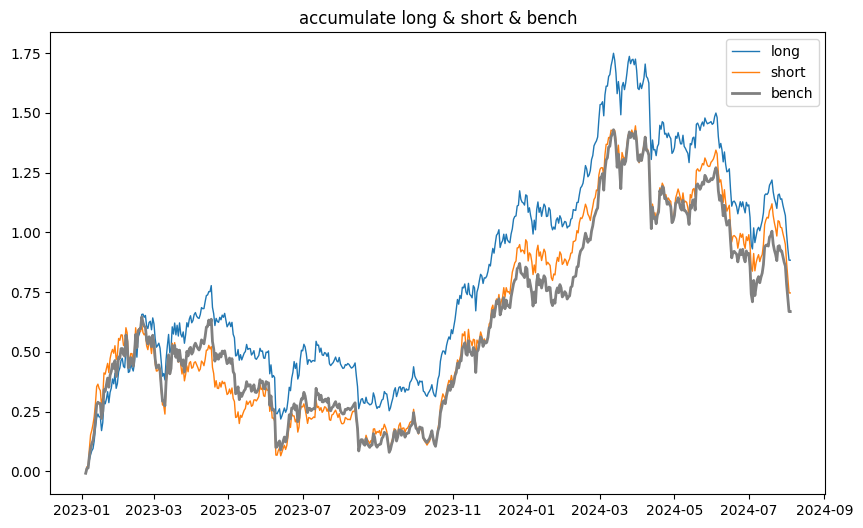

long: 
ann_return = 0.5568  sharpe = 0.8174  maxdd = 0.315  calmar_ratio = 1.7677  

short: 
ann_return = 0.4704  sharpe = 0.6766  maxdd = 0.3404  calmar_ratio = 1.3818  

bench: 
ann_return = 0.4211  sharpe = 0.6064  maxdd = 0.3443  calmar_ratio = 1.2233  



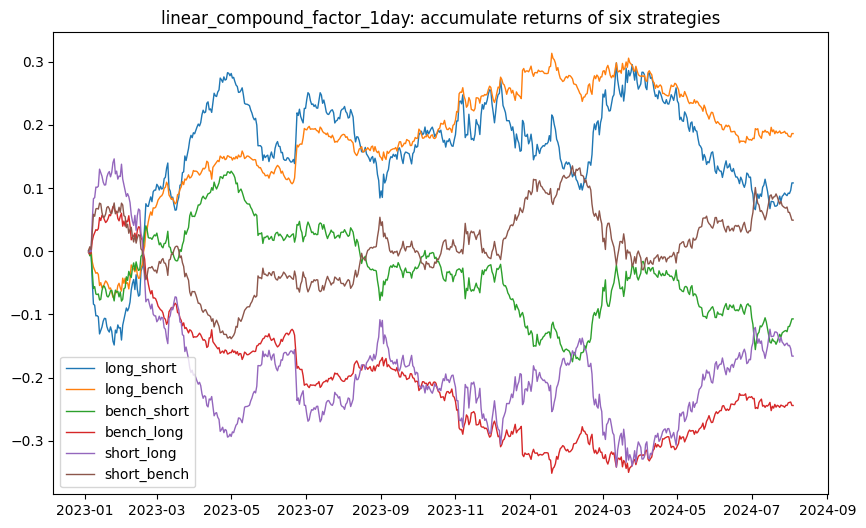

long_short: 
ann_return = 0.0681  sharpe = 0.2966  maxdd = 0.1789  calmar_ratio = 0.3808  

long_bench: 
ann_return = 0.1174  sharpe = 0.9188  maxdd = 0.1079  calmar_ratio = 1.0881  

bench_short: 
ann_return = -0.0675  sharpe = -0.4255  maxdd = 0.2677  calmar_ratio = -0.2521  

bench_long: 
ann_return = -0.1539  sharpe = -1.2045  maxdd = 0.3942  calmar_ratio = -0.3904  

short_long: 
ann_return = -0.1046  sharpe = -0.4555  maxdd = 0.4255  calmar_ratio = -0.246  

short_bench: 
ann_return = 0.031  sharpe = 0.1954  maxdd = 0.1996  calmar_ratio = 0.1553  



In [18]:
factors_np = factors[columns].to_numpy()
ret_np = ret[columns].to_numpy()

def factor_stats(n, pnl:pl.Series):
    net_value = pnl.cum_sum() + 1.0
    sharpe = n ** 0.5 * pnl.mean() / pnl.std()
    ann_return = n * pnl.mean()
    maxdd = (-(net_value / net_value.cum_max() - 1)).max()
    calmar_ratio = ann_return / maxdd

    print("ann_return =", round(ann_return, 4), end='  ')
    print("sharpe =", round(sharpe, 4), end='  ')
    print("maxdd =", round(maxdd, 4), end='  ')
    print("calmar_ratio =", round(calmar_ratio, 4), end='  ')


# 求每一行的分位数
percentage = 0.5
quantiles = np.nanquantile(factors_np, [1 - percentage, percentage], axis=1)

# 把quantiles[0]和[1]变成factors_np的shape
f = lambda x: quantiles[x][:, None].repeat(factors_np.shape[1], axis=-1)
long_quantile, short_quantile = f(0), f(1)

# print (f'quantiles: {quantiles} .  long_quantile: {long_quantile}, short_quantile: {short_quantile}')

# return before fee
long = np.nan_to_num(np.nan_to_num(ret_np * (factors_np > long_quantile), 0.0).sum(axis=1) / (factors_np > long_quantile).sum(axis=1) , 0.0)
short = np.nan_to_num(np.nan_to_num(ret_np * (factors_np < long_quantile), 0.0).sum(axis=1) / (factors_np < long_quantile).sum(axis=1) , 0.0)
bench = np.nan_to_num(np.nanmean(ret_np, axis=1), 0.0)

# return after fee
long_fee = pl.Series(long - 2 * commission)
short_fee = pl.Series(short - 2 * commission)
bench_fee = pl.Series(bench - 2 * commission)

long_short = pl.Series(long - short - 2 * commission)
long_bench = pl.Series(long - bench - 2 * commission)
bench_short = pl.Series(bench - short - 2 * commission)
bench_long = pl.Series(bench - long - 2 * commission)
short_long = pl.Series(short - long - 2 * commission)
short_bench = pl.Series(short - bench - 2 * commission)

long_cum = long_fee.cum_sum()
short_cum = short_fee.cum_sum()
bench_cum = bench_fee.cum_sum()

long_short_cum = long_short.cum_sum()
long_bench_cum = long_bench.cum_sum()
bench_short_cum = bench_short.cum_sum()
bench_long_cum = bench_long.cum_sum()
short_long_cum = short_long.cum_sum()
short_bench_cum = short_bench.cum_sum()

plt.figure(figsize=(10, 6))
plt.plot(factors["open_time"].to_pandas(), long_cum.to_pandas(), label='long', linewidth=1)
plt.plot(factors["open_time"].to_pandas(), short_cum.to_pandas(), label='short', linewidth=1)
plt.plot(factors["open_time"].to_pandas(), bench_cum.to_pandas(), label='bench', linewidth=2, color="gray")
plt.title("accumulate long & short & bench")
plt.legend()
plt.show()

# print (long_cum.shape, short_cum.shape, bench_cum.shape)
# print (long_cum, short_cum, bench_cum)
# print (f'factor dim: {factors.shape}, ret dim: {ret.shape}')
# print (factors)
# print (factors["open_time"].to_pandas())

# 因子评价指标
n = 365 if AGG_TO_WEEK == 0 else 52
print("long: ")
factor_stats(n, long_fee)
print("\n")
print("short: ")
factor_stats(n, short_fee)
print("\n")
print("bench: ")
factor_stats(n, bench_fee)
print("\n")


plt.figure(figsize=(10, 6))
plt.plot(factors["open_time"].to_pandas(), long_short_cum.to_pandas(), label='long_short', linewidth=1)
plt.plot(factors["open_time"].to_pandas(), long_bench_cum.to_pandas(), label='long_bench', linewidth=1)
plt.plot(factors["open_time"].to_pandas(), bench_short_cum.to_pandas(), label='bench_short', linewidth=1)
plt.plot(factors["open_time"].to_pandas(), bench_long_cum.to_pandas(), label='bench_long', linewidth=1)
plt.plot(factors["open_time"].to_pandas(), short_long_cum.to_pandas(), label='short_long', linewidth=1)
plt.plot(factors["open_time"].to_pandas(),short_bench_cum.to_pandas(), label='short_bench', linewidth=1)
plt.title(f"{FACTOR_NAME}: accumulate returns of six strategies")
plt.legend()
plt.show()


# 因子评价指标
print("long_short: ")
factor_stats(n, long_short)
print("\n")

print("long_bench: ")
factor_stats(n, long_bench)
print("\n")

print("bench_short: ")
factor_stats(n, bench_short)
print("\n")

print("bench_long: ")
factor_stats(n, bench_long)
print("\n")

print("short_long: ")
factor_stats(n, short_long)
print("\n")

print("short_bench: ")
factor_stats(n, short_bench)
print("\n")

###################################################################################################################


## 分组return

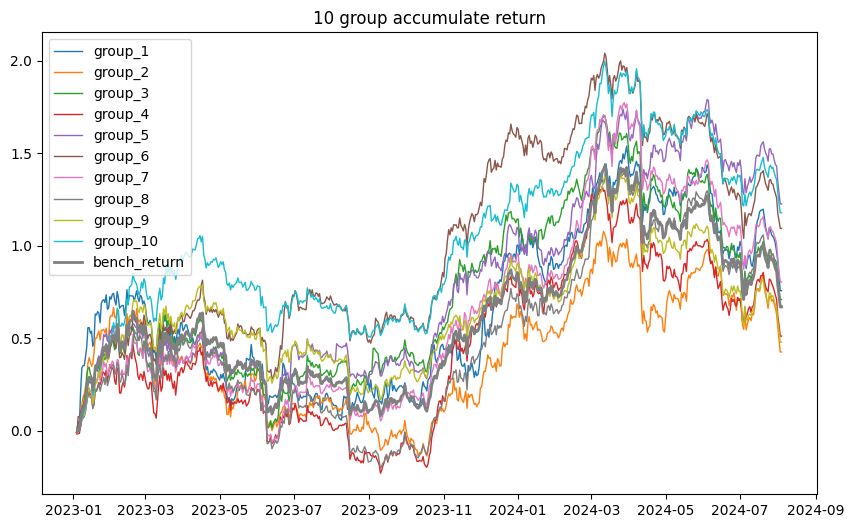

group_1: 
ann_return = 0.4767  sharpe = 0.588  maxdd = 0.4003  calmar_ratio = 1.191  

group_2: 
ann_return = 0.2676  sharpe = 0.3537  maxdd = 0.4825  calmar_ratio = 0.5547  

group_3: 
ann_return = 0.4466  sharpe = 0.5829  maxdd = 0.3814  calmar_ratio = 1.1708  

group_4: 
ann_return = 0.3218  sharpe = 0.439  maxdd = 0.4745  calmar_ratio = 0.6781  

group_5: 
ann_return = 0.7723  sharpe = 1.0303  maxdd = 0.3129  calmar_ratio = 2.4686  

group_6: 
ann_return = 0.6888  sharpe = 0.9451  maxdd = 0.3294  calmar_ratio = 2.0911  

group_7: 
ann_return = 0.5064  sharpe = 0.6977  maxdd = 0.393  calmar_ratio = 1.2887  

group_8: 
ann_return = 0.4261  sharpe = 0.5995  maxdd = 0.4841  calmar_ratio = 0.8802  

group_9: 
ann_return = 0.3011  sharpe = 0.4359  maxdd = 0.3825  calmar_ratio = 0.7872  

group_10: 
ann_return = 0.7424  sharpe = 1.0668  maxdd = 0.2731  calmar_ratio = 2.7182  



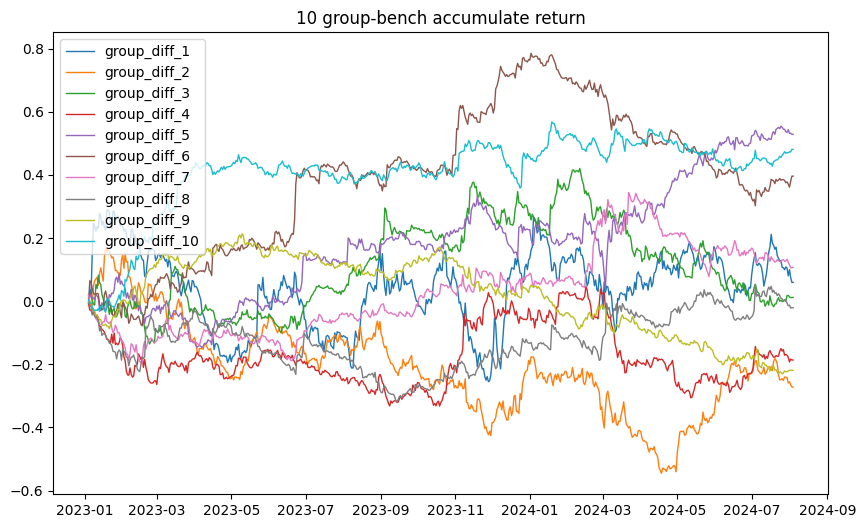

group_diff_1: 
ann_return = 0.0373  sharpe = 0.0744  maxdd = 0.4224  calmar_ratio = 0.0884  

group_diff_2: 
ann_return = -0.1717  sharpe = -0.497  maxdd = 0.6119  calmar_ratio = -0.2806  

group_diff_3: 
ann_return = 0.0072  sharpe = 0.0226  maxdd = 0.3082  calmar_ratio = 0.0234  

group_diff_4: 
ann_return = -0.1176  sharpe = -0.4239  maxdd = 0.3369  calmar_ratio = -0.349  

group_diff_5: 
ann_return = 0.3329  sharpe = 1.1518  maxdd = 0.2214  calmar_ratio = 1.504  

group_diff_6: 
ann_return = 0.2495  sharpe = 0.8711  maxdd = 0.2706  calmar_ratio = 0.9218  

group_diff_7: 
ann_return = 0.067  sharpe = 0.2621  maxdd = 0.21  calmar_ratio = 0.3193  

group_diff_8: 
ann_return = -0.0133  sharpe = -0.0536  maxdd = 0.3175  calmar_ratio = -0.0418  

group_diff_9: 
ann_return = -0.1383  sharpe = -0.7781  maxdd = 0.3659  calmar_ratio = -0.3779  

group_diff_10: 
ann_return = 0.303  sharpe = 1.3987  maxdd = 0.1003  calmar_ratio = 3.0214  

long_group_index_list: [10], short_group_index_list: [

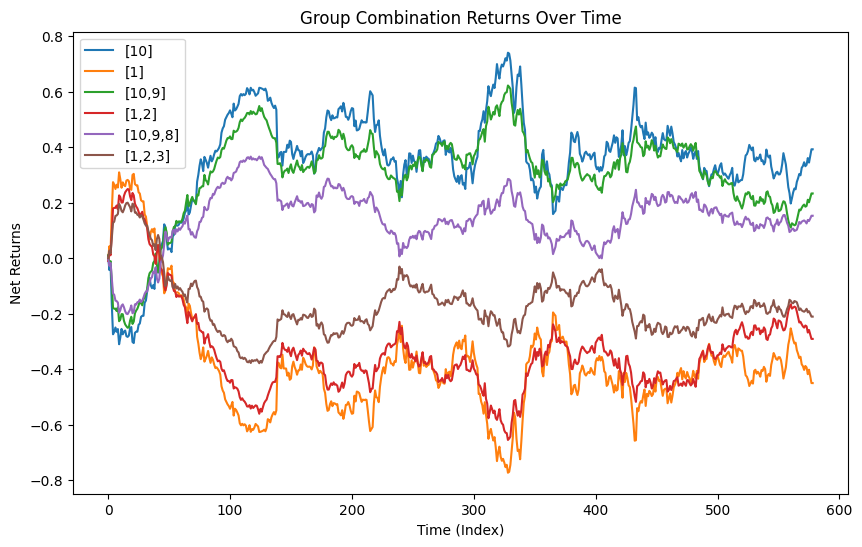

In [19]:
GROUP_NUM = 10

quantiles = np.nanquantile(factors_np, np.linspace(0, 1, GROUP_NUM + 1), axis=1)
total_count = np.count_nonzero(~np.isnan(factors_np), axis=1)
f = lambda x: quantiles[x][:, None].repeat(factors_np.shape[1], axis=-1)

#bench_return = np.nan_to_num(ret_np, 0.0).mean(axis=1)
bench_return = np.nan_to_num(np.nanmean(ret_np, axis=1), 0.0)
bench_return_fee = np.nan_to_num(np.nanmean(ret_np, axis=1), 0.0) - 2 * commission
group_return = np.zeros((factors_np.shape[0], GROUP_NUM))
group_diff_return = np.zeros((factors_np.shape[0], GROUP_NUM))


for i in range(1, GROUP_NUM + 1):
    # 计算在当前分位数范围内的总收益。如果因子值位于该分位数的范围内，则相应的收益被计入总和。
    ret_sum = np.nan_to_num(ret_np * (f(i-1) <= factors_np) * (factors_np <= f(i)), 0.0).sum(axis=1)
    # 计算当前分位数范围内的有效数据点数
    ret_count = np.nan_to_num((f(i-1) <= factors_np) * (factors_np <= f(i)), 0.0).sum(axis=1)
    group_return[:, i-1] = ret_sum / ret_count - 2 * commission 
    group_diff_return[:, i-1] = ret_sum / ret_count - bench_return - 2 * commission


group_return = np.nan_to_num(group_return)
group_diff_return = np.nan_to_num(group_diff_return)


plt.figure(figsize=(10, 6))
plt.title(f"{GROUP_NUM} group accumulate return")
for i in range(GROUP_NUM):
    plt.plot(factors["open_time"].to_pandas(), np.cumsum(group_return[:, i]), label=f"group_{i+1}", linewidth=1)
plt.plot(factors["open_time"].to_pandas(), np.cumsum(bench_return_fee), label=f"bench_return", linewidth=2, color="gray")
plt.legend()
plt.show()

for i in range(GROUP_NUM):
    print(f"group_{i+1}: ")
    net_value = np.cumsum(group_return[:, i]) + 1.0
    sharpe = n ** 0.5 * group_return[:, i].mean() / group_return[:, i].std()
    ann_return = n * group_return[:, i].mean()
    maxdd = (-(net_value / np.maximum.accumulate(net_value) - 1)).max()
    calmar_ratio = ann_return / maxdd
    print("ann_return =", round(ann_return, 4), end='  ')
    print("sharpe =", round(sharpe, 4), end='  ')
    print("maxdd =", round(maxdd, 4), end='  ')
    print("calmar_ratio =", round(calmar_ratio, 4), end='  ')
    print("\n")


plt.figure(figsize=(10, 6))
plt.title(f"{GROUP_NUM} group-bench accumulate return")
for i in range(GROUP_NUM):
    plt.plot(factors["open_time"].to_pandas(), np.cumsum(group_diff_return[:, i]), label=f"group_diff_{i+1}", linewidth=1)
plt.legend()
plt.show()

for i in range(GROUP_NUM):
    print(f"group_diff_{i+1}: ")
    net_value = np.cumsum(group_diff_return[:, i]) + 1.0
    sharpe = n ** 0.5 * group_diff_return[:, i].mean() / group_diff_return[:, i].std()
    ann_return = n * group_diff_return[:, i].mean()
    maxdd = (-(net_value / np.maximum.accumulate(net_value) - 1)).max()
    calmar_ratio = ann_return / maxdd
    print("ann_return =", round(ann_return, 4), end='  ')
    print("sharpe =", round(sharpe, 4), end='  ')
    print("maxdd =", round(maxdd, 4), end='  ')
    print("calmar_ratio =", round(calmar_ratio, 4), end='  ')
    print("\n")

###################################################################################################################
def GetGroupCombinationReturn (input_factors_np: np.ndarray, input_ret_np: np.ndarray, group_index_list: list)-> np.ndarray:
    total_ret_sum = np.zeros(input_factors_np.shape[0])
    total_ret_count = np.zeros(input_factors_np.shape[0])
    
    # Loop through each group index in the list
    for i in group_index_list:
        assert i >= 1 and i <= GROUP_NUM, f"Group index {i} is out of range"
        # Compute the mask for the current group
        group_mask = (f(i-1) <= input_factors_np) & (input_factors_np <= f(i))
        
        # Calculate the return sum for the current group
        ret_sum = np.nan_to_num(input_ret_np * group_mask, nan=0.0).sum(axis=1)
        total_ret_sum += ret_sum
        
        # Calculate the count of returns for the current group
        ret_count = np.nan_to_num(group_mask, nan=0.0).sum(axis=1)
        total_ret_count += ret_count
    
    # Compute the average return per count, adjust for commission
    return  total_ret_sum / total_ret_count - 2 * commission
    

GROUP_COMBINATION_LIST = [[20], [19], [18], [20, 19], [20, 19, 18], [1], [2], [3], [1, 2], [1, 2, 3]]  # start from 1
GROUP_COMBINATION_LIST = [[10], [1], [10, 9], [1, 2], [10, 9, 8], [1, 2, 3]] # start from 1, group num = 10
group_combination_result = [[] for _ in range(len(GROUP_COMBINATION_LIST))]

tmp = []

for long_group_index_list in GROUP_COMBINATION_LIST:
    short_group_index_list = [(GROUP_NUM + 1 - i) for i in long_group_index_list]
    long_return = GetGroupCombinationReturn(factors_np, ret_np, long_group_index_list)
    short_return = GetGroupCombinationReturn(factors_np, ret_np, short_group_index_list)
    cur_return = long_return - short_return - 2 * commission
    tmp.append (cur_return)
    print (f'long_group_index_list: {long_group_index_list}, short_group_index_list: {short_group_index_list}', end = ' === ')
    factor_stats (n, pl.Series(np.nan_to_num(cur_return, 0.0)))
    print (' ')
    

plt.figure(figsize=(10, 6))  # Optional: Specifies the figure size

for idx, returns in enumerate(tmp):
    cumulative_returns = np.cumsum(np.nan_to_num (returns, 0))  # Calculate cumulative returns
    # plt.plot(cumulative_returns, label=f'Group Combination {idx + 1}')  # Plot cumulative returns
    idx_str = ','.join([str(i) for i in GROUP_COMBINATION_LIST[idx]])
    plt.plot(cumulative_returns, label = '[' + idx_str + ']')  # Plot cumulative returns


# Adding labels and title for clarity
plt.title('Group Combination Returns Over Time')
plt.xlabel('Time (Index)')
plt.ylabel('Net Returns')
plt.legend()  

In [20]:
def plot_array(title: str, array: np.ndarray, cumulative: bool):
    """
    Plot either the original array or its cumulative sum based on a boolean flag.

    Args:
    title (str): Title of the plot.
    array (numpy.ndarray): NumPy array to be plotted.
    cumulative (bool): If True, plot the cumulative sum of the array. If False, plot the original array.
    """
    if cumulative:
        # Calculate the cumulative sum of the array if the flag is True
        array_to_plot = np.cumsum(np.nan_to_num(array, nan=0.0))
        ylabel = 'Cumulative Sum'
    else:
        # Use the original array if the flag is False
        array_to_plot = array
        ylabel = 'Values'
    
    # Create the plot
    # plt.figure(figsize=(10, 6))
    plt.figure(figsize=(5, 3))
    plt.plot(array_to_plot, marker='o', linestyle='-', color='blue', linewidth = 1, markersize = 1)
    # plt.title(title + ' cumulative' if cumulative else '')
    if cumulative:
        plt.title(title + ' (cumulative)')
    else:
        plt.title(title)
    plt.xlabel('Index')
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

## IC 分析（因子值与return）

In [21]:
def print_statistics(ic_array: np.ndarray, description):
    valid_ic = ic_array[~np.isnan(ic_array)]  # Filter out NaN values for statistics
    mean_ic = np.mean(valid_ic)
    median_ic = np.median(valid_ic)
    std_ic = np.std(valid_ic)
    significant_count = np.sum(np.abs(valid_ic) > 0.1)  # Count ICs significantly different from 0
    significant_proportion = significant_count / len(valid_ic) if len(valid_ic) > 0 else 0

    print(f"{description} Statistics:")
    print(f"Mean IC: {mean_ic:.3f}")
    print(f"Median IC: {median_ic:.3f}")
    print(f"Standard Deviation: {std_ic:.3f}")
    print(f"Count of Significant ICs (|IC| > 0.1): {significant_count}")
    print(f"Proportion of Significant ICs: {significant_proportion:.2%}\n")

In [22]:
def calculate_statistics(ic_array: np.ndarray):
    valid_ic = ic_array[~np.isnan(ic_array)]  # Filter out NaN values for statistics
    
    if len(valid_ic) == 0:
        return {}  # Return empty dictionary if no valid ICs

    mean_ic = np.mean(valid_ic)
    median_ic = np.median(valid_ic)
    std_ic = np.std(valid_ic)
    significant_count = np.sum(np.abs(valid_ic) > 0.1)  # Count ICs significantly different from 0
    significant_proportion = significant_count / len(valid_ic)
    
    # Calculate Information Ratio (IR)
    ir = mean_ic / std_ic if std_ic != 0 else float('inf')
    
    # Calculate Skewness and Kurtosis
    skewness = stats.skew(valid_ic)
    kurtosis = stats.kurtosis(valid_ic)

    # Perform t-test against the null hypothesis that mean = 0
    t_statistic, p_value = stats.ttest_1samp(valid_ic, 0)

    # Compile results into a dictionary
    results = {
        'Mean IC': mean_ic,
        'Median IC': median_ic,
        'Standard Deviation': std_ic,
        'Count of Significant ICs (|IC| > 0.1)': significant_count,
        'Proportion of Significant ICs': significant_proportion,
        'Information Ratio (IR)': ir,
        'Skewness': skewness,
        'Kurtosis': kurtosis,
        'T-Value': t_statistic,
        'P-Value': p_value
    }
    
    return results

In [23]:
import numpy as np
from scipy import stats

def calculate_statistics(ic_array: np.ndarray):
    valid_ic = ic_array[~np.isnan(ic_array)]  # Filter out NaN values for statistics
    
    if len(valid_ic) == 0:
        return {}  # Return empty dictionary if no valid ICs

    mean_ic = round(np.mean(valid_ic), 4)
    median_ic = round(np.median(valid_ic), 4)
    std_ic = round(np.std(valid_ic), 4)
    significant_count = np.sum(np.abs(valid_ic) > 0.1)  # Count ICs significantly different from 0
    significant_proportion = round(significant_count / len(valid_ic), 4)
    
    # Calculate Information Ratio (IR)
    ir = round(mean_ic / std_ic, 4) if std_ic != 0 else float('inf')
    
    # Calculate Skewness and Kurtosis
    skewness = round(stats.skew(valid_ic), 4)
    kurtosis = round(stats.kurtosis(valid_ic), 4)

    # Perform t-test against the null hypothesis that mean = 0
    t_statistic, p_value = stats.ttest_1samp(valid_ic, 0)
    t_statistic = round(t_statistic, 4)
    p_value = round(p_value, 4)

    # Compile results into a dictionary
    results = {
        'Mean IC': mean_ic,
        'Median IC': median_ic,
        'Standard Deviation': std_ic,
        'Count of Significant ICs (|IC| > 0.1)': significant_count,
        'Proportion of Significant ICs': significant_proportion,
        'Information Ratio (IR)': ir,
        'Skewness': skewness,
        'Kurtosis': kurtosis,
        'T-Value': t_statistic,
        'P-Value': p_value
    }
    
    return results


ic stat dict {'Mean IC': 0.0438, 'Median IC': 0.0393, 'Standard Deviation': 0.1144, 'Count of Significant ICs (|IC| > 0.1)': 244, 'Proportion of Significant ICs': 0.4221, 'Information Ratio (IR)': 0.3829, 'Skewness': 0.0647, 'Kurtosis': -0.2428, 'T-Value': 9.2024, 'P-Value': 0.0}


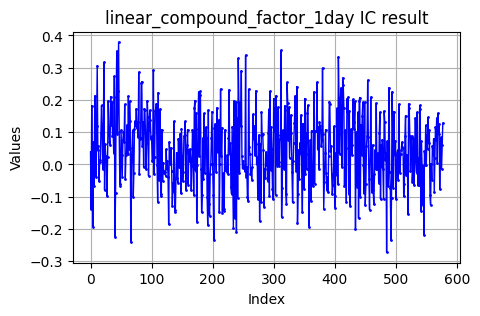

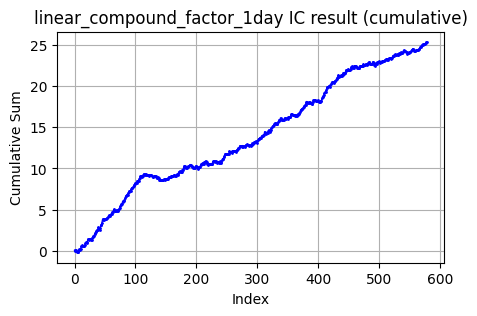

rank ic stat dict {'Mean IC': 0.0438, 'Median IC': 0.0388, 'Standard Deviation': 0.1144, 'Count of Significant ICs (|IC| > 0.1)': 244, 'Proportion of Significant ICs': 0.4214, 'Information Ratio (IR)': 0.3829, 'Skewness': 0.0666, 'Kurtosis': -0.2392, 'T-Value': 9.2012, 'P-Value': 0.0}


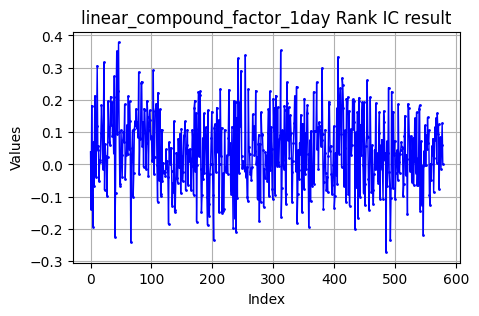

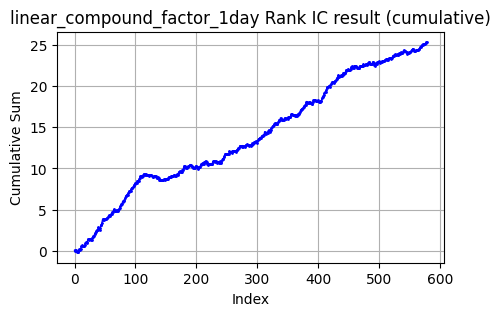

In [24]:
import numpy as np
from scipy.stats import kendalltau, rankdata, spearmanr
from scipy import stats

USE_PEARSOM = 0
USE_SPEARMAN = 0

num_timestamps = factors_np.shape[0]
num_stocks = factors_np.shape[1]

# Initialize an array to store the IC values
ic_values = np.zeros(num_timestamps)
rank_ic_values = np.zeros(num_timestamps)

for i in range(num_timestamps):
    # Extract the factor values and return values for the current timestamp
    factor_values = factors_np[i, :]
    returns = ret_np[i, :]

    # Find indices where both factor_values and returns are not NaN
    valid_indices = ~(np.isnan(factor_values) | np.isnan(returns))

    # Filter out NaN values
    factor_values_valid = factor_values[valid_indices]
    returns_valid = returns[valid_indices]

    # Rank the valid arrays
    ranked_factors = rankdata(factor_values_valid)
    ranked_returns = rankdata(returns_valid)

    # Calculate the Pearson correlation coefficient (IC)
    if len(factor_values_valid) > 1:
        if USE_PEARSOM:
            ic_values[i] = np.corrcoef(factor_values_valid, returns_valid)[0, 1]
            rank_ic_values[i] = np.corrcoef(ranked_factors, ranked_returns)[0, 1]
        elif USE_SPEARMAN:
            ic_values[i] = spearmanr(factor_values_valid, returns_valid).correlation
            rank_ic_values[i] = spearmanr(ranked_factors, ranked_returns).correlation
        else:
            tau, _ = kendalltau(factor_values_valid, returns_valid)
            rank_tau, _ = kendalltau(ranked_factors, ranked_returns)
            # print (f'tau: {tau} == factor_values: {factor_values_valid} == returns: {returns_valid}')
            ic_values[i] = tau
            rank_ic_values[i] = rank_tau
    else:
        ic_values[i] = np.nan

# print_statistics(ic_values, "IC")
ic_stat: dict = calculate_statistics (ic_values)
print ('ic stat dict', ic_stat)
plot_array(f"{FACTOR_NAME} IC result", ic_values, cumulative = False)
plot_array(f"{FACTOR_NAME} IC result", ic_values, cumulative = True)

# print_statistics(rank_ic_values, "Rank IC")
rank_ic_stat: dict = calculate_statistics (rank_ic_values)
print ('rank ic stat dict', rank_ic_stat)
plot_array(f"{FACTOR_NAME} Rank IC result", rank_ic_values, cumulative = False)
plot_array(f"{FACTOR_NAME} Rank IC result", rank_ic_values, cumulative = True)


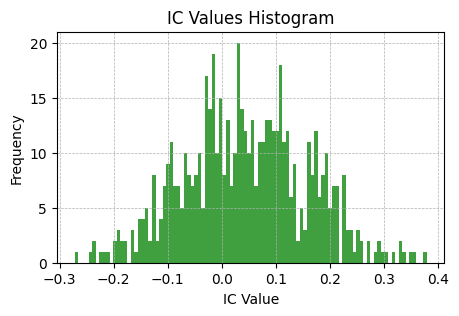

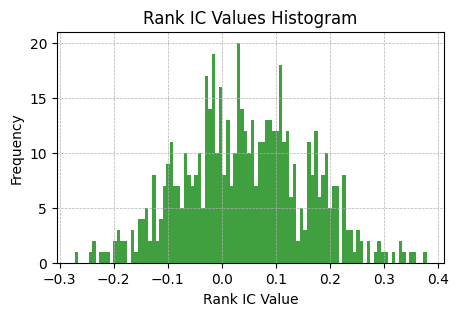

In [25]:
def plot_histogram(data, title='Histogram', xlabel='Value', ylabel='Frequency', bins=20, color='blue'):
    """
    Plots a histogram for the given data array.
    
    Parameters:
        data (array-like): The data array for which the histogram will be plotted.
        title (str): The title of the histogram plot.
        xlabel (str): The label for the x-axis.
        ylabel (str): The label for the y-axis.
        bins (int): The number of bins in the histogram.
        color (str): The color of the histogram bars.
    """
    # Filter out NaN values for accurate plotting
    valid_data = data[~np.isnan(data)]
    
    # Create the histogram
    # plt.figure(figsize=(10, 6))
    plt.figure(figsize=(5, 3))
    plt.hist(valid_data, bins=bins, color=color, alpha=0.75)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()
plot_histogram(ic_values, title='IC Values Histogram', xlabel='IC Value', ylabel='Frequency', bins=100, color='green')
plot_histogram(rank_ic_values, title='Rank IC Values Histogram', xlabel='Rank IC Value', ylabel='Frequency', bins=100, color='green')

## Group IC

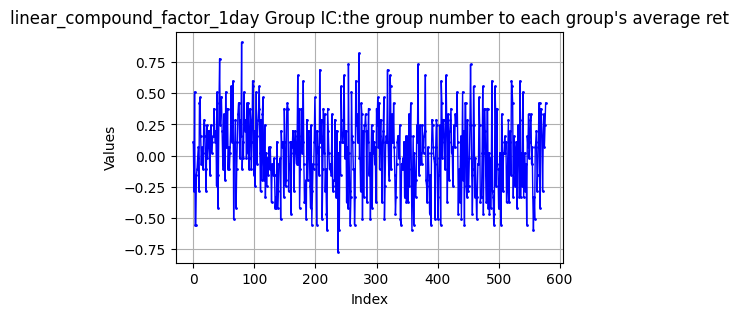

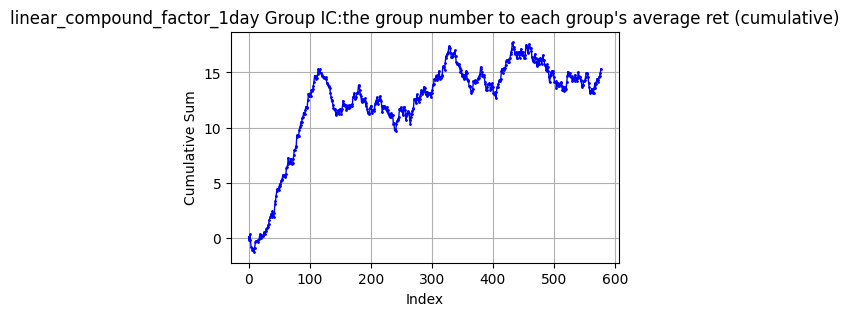

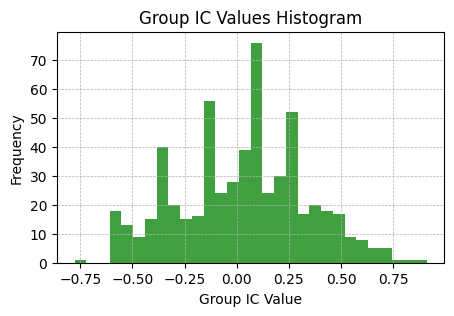

{'Mean IC': 0.0265,
 'Median IC': 0.0222,
 'Standard Deviation': 0.305,
 'Count of Significant ICs (|IC| > 0.1)': 456,
 'Proportion of Significant ICs': 0.7889,
 'Information Ratio (IR)': 0.0869,
 'Skewness': 0.0089,
 'Kurtosis': -0.4567,
 'T-Value': 2.0893,
 'P-Value': 0.0371}

In [26]:
import numpy as np
from scipy.stats import kendalltau

group_ic_results = []

# Iterate over each time slice
for i in range(factors_np.shape[0]):
    factor_values = factors_np[i, :]
    returns = ret_np[i, :]

    # Filter out NaNs
    valid_mask = ~np.isnan(factor_values) & ~np.isnan(returns)
    valid_factors = factor_values[valid_mask]
    valid_returns = returns[valid_mask]

    # Check if there are enough non-NaN data points
    if len(valid_factors) >= GROUP_NUM:
        # Sort indices based on factor values
        sorted_indices = np.argsort(valid_factors)
        sorted_returns = valid_returns[sorted_indices]

        # Divide into groups
        group_edges = np.linspace(0, len(sorted_indices), GROUP_NUM + 1, dtype=int)
        group_returns = []

        for j in range(GROUP_NUM):
            # Indices for j-th group
            start_idx = group_edges[j]
            end_idx = group_edges[j + 1]

            # Calculate average return for the group
            group_average_return = np.nanmean(sorted_returns[start_idx:end_idx])
            group_returns.append(group_average_return)

        # Calculate IC between group indices and group average returns
        group_indices = np.arange(1, GROUP_NUM + 1)
        tau, _ = kendalltau(group_indices, group_returns)
        group_ic_results.append(tau)

group_ic_results_np = np.array(group_ic_results)

# print_statistics(group_ic_results_np, "Group IC")
group_ic_stat = calculate_statistics(group_ic_results_np)
plot_array(f"{FACTOR_NAME} Group IC:the group number to each group's average ret", group_ic_results_np, cumulative = False)
plot_array(f"{FACTOR_NAME} Group IC:the group number to each group's average ret", group_ic_results_np, cumulative = True)

plot_histogram(group_ic_results_np, title='Group IC Values Histogram', xlabel='Group IC Value', ylabel='Frequency', bins=30, color='green')
group_ic_stat 

### 汇总 IC, rank IC, group IC结果

In [27]:
def AnalyseICArray (ic_array: np.ndarray, type: str = 'IC'):
    """
    Analyze the IC array by calculating various statistics and plotting histograms.

    Args:
    ic_array (numpy.ndarray): The array of IC values to be analyzed.
    type (str): The type of IC values being analyzed. Can be 'IC', 'Rank IC', or 'Group IC'.
    """
    # Filter out NaN values for accurate statistics
    valid_ic = ic_array[~np.isnan(ic_array)]
    
    # Calculate the mean, median, and standard deviation of the IC values
    mean_ic = np.mean(valid_ic)
    median_ic = np.median(valid_ic)
    std_ic = np.std(valid_ic)
    
    # Count the number of IC values significantly different from 0
    significant_count = np.sum(np.abs(valid_ic) > 0.1)
    
    # Calculate the proportion of significant IC values
    significant_proportion = significant_count / len(valid_ic) if len(valid_ic) > 0 else 0
    
    # Print the statistics
    print(f"{type} Statistics:")
    print(f"Mean {type}: {mean_ic:.3f}")
    print(f"Median {type}: {median_ic:.3f}")
    print(f"Standard Deviation: {std_ic:.3f}")
    print(f"Count of Significant {type}s (|{type}| > 0.1): {significant_count}")
    print(f"Proportion of Significant {type}s: {significant_proportion:.2%}\n")
    

ic_values, rank_ic_values, group_ic_results
AnalyseICArray (ic_values, 'IC')


IC Statistics:
Mean IC: 0.044
Median IC: 0.039
Standard Deviation: 0.114
Count of Significant ICs (|IC| > 0.1): 244
Proportion of Significant ICs: 42.21%



## R方分析

Mean R-squared: 0.0530
Median R-squared: 0.0143
Standard Deviation of R-squared: 0.1047


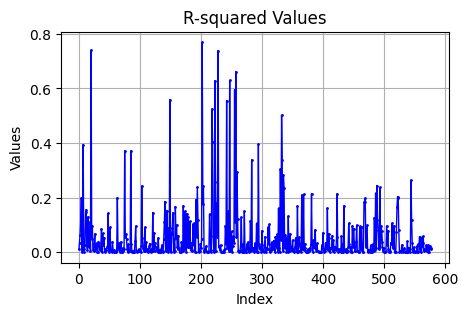

In [28]:
import numpy as np
import statsmodels.api as sm

r_squared_values = []  # Assuming you've initialized this list outside the loop

for i in range(factors_np.shape[0]):
    # 提取第i行作为X（因子值）和y（回报率）
    X = factors_np[i, :]
    y = ret_np[i, :]

    # 仅保留X和y中均非NaN的数据点
    valid_mask = ~np.isnan(X) & ~np.isnan(y)  # Create a mask to filter valid entries
    X_valid = X[valid_mask]
    y_valid = y[valid_mask]

    if len(X_valid) > 0:  # Ensure there is at least one valid data point to fit the model
        # 为X添加常数项
        X_valid = sm.add_constant(X_valid)

        # 创建并拟合OLS模型
        model = sm.OLS(y_valid, X_valid)
        results = model.fit()

        # 存储每个模型的R-squared值
        r_squared_values.append(results.rsquared)

        # # 验证R-squared值是否正确
        # y_hat = results.predict(X_valid)  # 计算预测值y_hat
        # ss_res = np.sum((y_valid - y_hat) ** 2)
        # ss_tot = np.sum((y_valid - np.mean(y_valid)) ** 2)
        # predicted_r_squared = 1 - (ss_res / ss_tot)
        # print (f'{(results.rsquared - predicted_r_squared):.4f} ==== cacl r_squared: {results.rsquared} == {predicted_r_squared}')
    else:
        # Optionally handle the case where no data is available to fit the model
        r_squared_values.append(np.nan)  # Append NaN or another placeholder to indicate no calculation was possible


# 移除NaN值以进行有效的统计分析
valid_r_squared = np.array(r_squared_values)[~np.isnan(r_squared_values)]

# 计算统计数据
mean_r_squared = np.mean(valid_r_squared)
median_r_squared = np.median(valid_r_squared)
std_r_squared = np.std(valid_r_squared)

# 打印统计数据
print(f'Mean R-squared: {mean_r_squared:.4f}')
print(f'Median R-squared: {median_r_squared:.4f}')
print(f'Standard Deviation of R-squared: {std_r_squared:.4f}')

plot_array('R-squared Values', np.array(valid_r_squared), cumulative = False)